# Triplet Loss with Faces -- Training the model

In [1]:
!pip install torch

In [2]:
!pip install pytorch-ignite

     |████████████████████████████████| 225kB 31.6MB/s 


In [3]:
!pip install mat73

In [4]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8MB 32.7MB/s 
     |████████████████████████████████| 174kB 51.3MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 133kB 56.7MB/s 
     |████████████████████████████████| 71kB 12.2MB/s 


In [5]:
!git clone https://github.com/mgornet/CNPEN

Cloning into 'CNPEN'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 155 (delta 24), reused 12 (delta 7), pack-reused 102
Receiving objects: 100% (155/155), 95.69 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (80/80), done.


### Check device

In [6]:
!nvidia-smi

Tue Jun 29 16:06:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Librairies

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd
import re

import sys
import os
import tarfile

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

In [8]:
%cd ./CNPEN/files/

from triplet import TripletGenerator, TripletLearner, TripletLoss, TripletLossRaw
from builder import create_dataframe, build_positive_pairs, build_negative_pairs
from prints import print_img_from_path, print_img_from_id, print_img_from_classid, print_img_category, print_from_gen, print_pairs, print_hist
from test_train_loops import training, testing

/content/CNPEN/files


In [9]:
!pwd

/content/CNPEN/files


### Generate Data

In [10]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

Extracting image files...


In [11]:
PATH = "lfw/lfw-deepfunneled/"

In [12]:
tic = perf_counter()
df, all_imgs, mean = create_dataframe()
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

Number of individuals:  5749
Number of total images:  13233
images weigh  1.14 GB
DataFrame creation: 1.8 min


In [13]:
df.head(10)

,Classid,Name,Path
0,0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg
5,5,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0001.jpg
6,5,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0002.jpg
7,5,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0003.jpg
8,5,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0004.jpg
9,6,Aaron_Pena,Aaron_Pena/Aaron_Pena_0001.jpg


### Build triplet

In [14]:
num_classes = len(df.Classid.unique())
print("Number of individuals: ", num_classes)

Number of individuals:  5749


In [15]:
indiv_min = df.Classid.min()
split_train_valid = int(num_classes * 0.75)
split_train_test = int(num_classes * 0.8)
indiv_max = df.Classid.max()

In [16]:
print(f"Train set from indiv {indiv_min} to {split_train_valid-1}")
print(f"Valid set from indiv {split_train_valid} to {split_train_test-1}")
print(f"Test set from indiv {split_train_test} to {indiv_max}")

Train set from indiv 0 to 4310
Valid set from indiv 4311 to 4598
Test set from indiv 4599 to 5748


In [17]:
df_train = df[df.Classid<split_train_valid]
df_valid = df[(df.Classid>=split_train_valid)&(df.Classid<split_train_test)]
df_test = df[df.Classid>=split_train_test]

In [18]:
print("training images: ", len(df_train))
print("validation images: ", len(df_valid))
print("testing images: ", len(df_test))
print("total images: ", len(df_train)+len(df_valid)+len(df_test))
print("len original: ", len(df))

training images:  10060
validation images:  586
testing images:  2587
total images:  13233
len original:  13233


In [19]:
df_valid.head()

,Classid,Name,Path
10060,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0001.jpg
10061,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0002.jpg
10062,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0003.jpg
10063,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0004.jpg
10064,4312,Pedro_Velasquez,Pedro_Velasquez/Pedro_Velasquez_0001.jpg


In [20]:
BATCH_SIZE = 128
BATCH_VALID_SIZE = 8
BATCH_TEST_SIZE = 32

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = TripletLearner().double()
model.to(device)

lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

margin = 0.2
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

epochs = 200

In [22]:
gen_train = TripletGenerator(df_train, all_imgs, BATCH_SIZE, device, model, margin, transform = True)
train_loader = DataLoader(gen_train, batch_size=None, shuffle=True)

gen_valid = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
valid_loader = DataLoader(gen_valid, batch_size=None, shuffle=True)

gen_test = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin)
test_loader = DataLoader(gen_test, batch_size=None, shuffle=True)

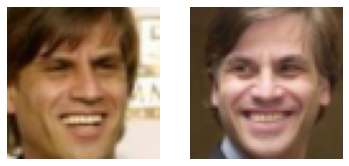

In [23]:
print_img_from_classid(df,7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

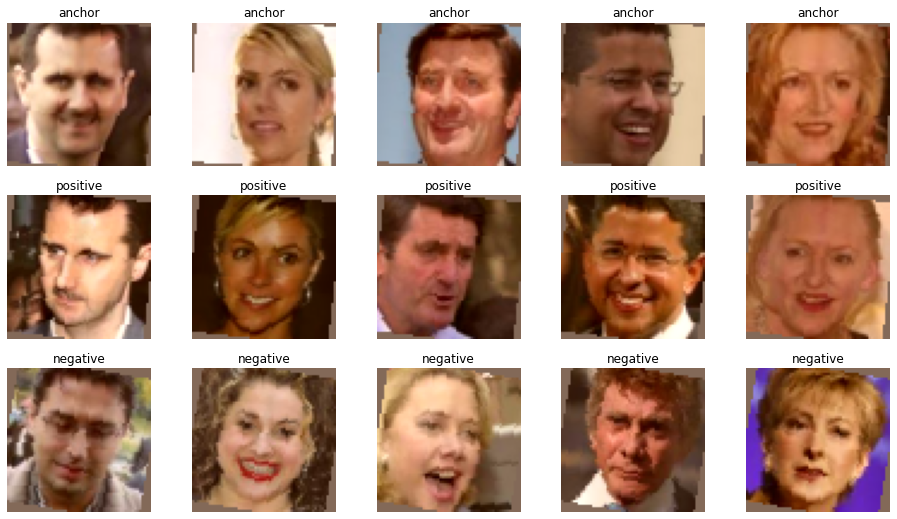

In [24]:
print_from_gen(gen_train,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

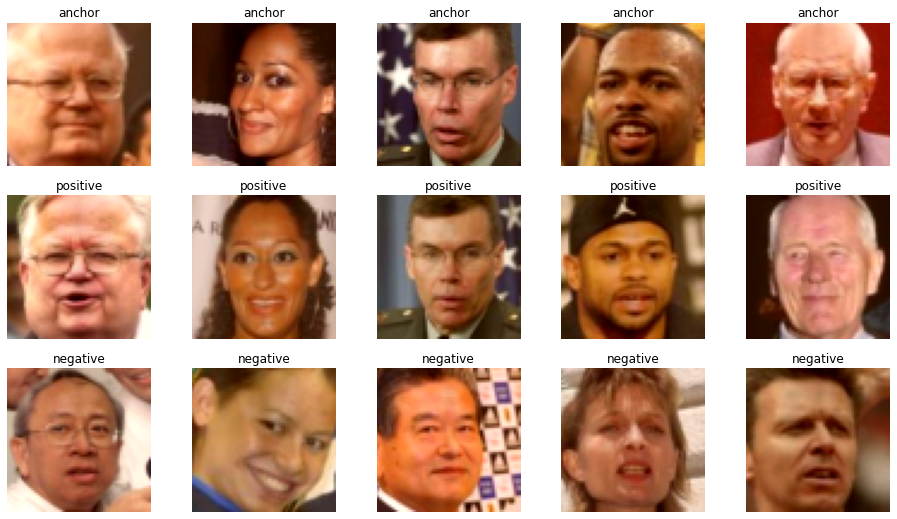

In [25]:
print_from_gen(gen_test,0)

### Training

In [54]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [55]:
wandb.init(project="triplet_faces",
           name="model_new_model_lr4",
           config={"batch_size": BATCH_SIZE,
                  "margin": margin,
                  "nb epochs": epochs,
                  "learning_rate" : lr,
                  "optimizer" : "Adam",
                  "criterion" : "euclidian square",
                  "dataset": "LFW",
                  "network": "standard-512",})

wandb: Currently logged in as: mgornet (use `wandb login --relogin` to force relogin)


In [ ]:
# model = TripletLearner().double()
# model.load_state_dict(torch.load("./model_new_gen.pth"))
# model.to(device)

In [ ]:
model = training(model, device, optimizer, criterion, epochs, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epochs: 1/200 - Loss: 0.1981


Epochs: 2/200 - Loss: 0.1913


Epochs: 3/200 - Loss: 0.1956


Epochs: 4/200 - Loss: 0.1913


Epochs: 5/200 - Loss: 0.1881


Epochs: 6/200 - Loss: 0.1796


Epochs: 7/200 - Loss: 0.1640


Epochs: 8/200 - Loss: 0.1507


Epochs: 9/200 - Loss: 0.1460


Epochs: 10/200 - Loss: 0.1323


Epochs: 11/200 - Loss: 0.1307


Epochs: 12/200 - Loss: 0.1366


Epochs: 13/200 - Loss: 0.1253


Epochs: 14/200 - Loss: 0.1298


Epochs: 15/200 - Loss: 0.1232


Epochs: 16/200 - Loss: 0.1317


Epochs: 17/200 - Loss: 0.1290


Epochs: 18/200 - Loss: 0.1300


Epochs: 19/200 - Loss: 0.1193


Epochs: 20/200 - Loss: 0.1245


Epochs: 21/200 - Loss: 0.1257


Epochs: 22/200 - Loss: 0.1211


Epochs: 23/200 - Loss: 0.1217


Epochs: 24/200 - Loss: 0.1214


Epochs: 25/200 - Loss: 0.1191


Epochs: 26/200 - Loss: 0.1183


Epochs: 27/200 - Loss: 0.1182


Epochs: 28/200 - Loss: 0.1248


Epochs: 29/200 - Loss: 0.1095


Epochs: 30/200 - Loss: 0.1122


Epochs: 31/200 - Loss: 0.1081


Epochs: 32/200 - Loss: 0.1103


Epochs: 33/200 - Loss: 0.1140


Epochs: 34/200 - Loss: 0.1099


Epochs: 35/200 - Loss: 0.1146


Epochs: 36/200 - Loss: 0.1144


Epochs: 37/200 - Loss: 0.1073


Epochs: 38/200 - Loss: 0.1154


Epochs: 39/200 - Loss: 0.1105


Epochs: 40/200 - Loss: 0.1100


Epochs: 41/200 - Loss: 0.1125


Epochs: 42/200 - Loss: 0.1027


Epochs: 43/200 - Loss: 0.1044


Epochs: 44/200 - Loss: 0.1021


Epochs: 45/200 - Loss: 0.1057


Epochs: 46/200 - Loss: 0.1094


Epochs: 47/200 - Loss: 0.1081


Epochs: 48/200 - Loss: 0.1006


Epochs: 49/200 - Loss: 0.1025


Epochs: 50/200 - Loss: 0.1031


Epochs: 51/200 - Loss: 0.1092


Epochs: 52/200 - Loss: 0.0921


Epochs: 53/200 - Loss: 0.0966


Epochs: 54/200 - Loss: 0.1020


Epochs: 55/200 - Loss: 0.0944


Epochs: 56/200 - Loss: 0.0981


Epochs: 57/200 - Loss: 0.0997


Epochs: 58/200 - Loss: 0.0932


Epochs: 59/200 - Loss: 0.0931


Epochs: 60/200 - Loss: 0.0874


Epochs: 61/200 - Loss: 0.0895


Epochs: 62/200 - Loss: 0.0885


Epochs: 63/200 - Loss: 0.0925


Epochs: 64/200 - Loss: 0.0922


Epochs: 65/200 - Loss: 0.0880


Epochs: 66/200 - Loss: 0.0896


Epochs: 67/200 - Loss: 0.0859


Epochs: 68/200 - Loss: 0.0888


Epochs: 69/200 - Loss: 0.0809


Epochs: 70/200 - Loss: 0.0859


Epochs: 71/200 - Loss: 0.0895


Epochs: 72/200 - Loss: 0.0894


Epochs: 73/200 - Loss: 0.0779


In [ ]:
torch.save(model.state_dict(), './'+wandb.run.name+'.pth')

In [ ]:
if wandb.run is not None:
    wandb.finish()

training step,899
training loss,0.09778
_runtime,1427
_timestamp,1624963057
_step,1899
validation step,899
validation loss,0.18728
epoch,99
mean training loss,0.08151
mean validation loss,0.09567


training step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training loss,███▅▅▅▆▅▃▄▅▄▄▅▃▄▃▃▄▃▃▂▂▁▄▂▃▂▁▂▃▁▁▂▂▁▂▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation loss,▅▆▅▄▅▅█▁▃▄▄▃▂▂▃▂▂▄▃▅▃▂▂▂▃▆▁▂▅▆▂▇▂▄▃▁▁▂▃▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mean training loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂
mean validation loss,██▇▅▅▅▅▃▅▅▃▄▃▂▃▂▃▃▂▃▃▂▃▁▂▄▂▃▄▄▂▃▁▄▂▂▂▃▃▃


### Test hard

In [ ]:
model = TripletLearner()
model.eval()
model.to(device)
gen = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, df, all_img_train_idx, device, model, margin, transform = True, mining="hard")
print_from_gen(gen,1)

In [ ]:
model = TripletLearner()
model.load_state_dict(torch.load("./model_semi_test.pth"))
model.eval()
model.to(device)
gen = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, df, all_img_train_idx, device, model, margin, transform = True, mining="hard")
print_from_gen(gen,1)

In [ ]:
model = TripletLearner()
model.load_state_dict(torch.load("./model4.pth"))
model.eval()
model.to(device)
gen = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, df, all_img_train_idx, device, model, margin, transform = True, mining="hard")
print_from_gen(gen,1)

In [ ]:
for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_loader, desc="Enumerate", leave=False)):
    print(anchor_img.shape)

In [ ]:
gen_train = TripletGenerator(Xa_train, Xp_train, 1, df, all_img_train_idx, device, model, margin, transform = True, mining="semi")
train_loader = DataLoader(gen_train, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_loader, desc="Enumerate", leave=False)):
    print(anchor_img.shape)

### Load Model

In [31]:
model = TripletLearner().double()
model.load_state_dict(torch.load("./model_new_model.pth"))
model.eval()

TripletLearner(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [32]:
model = model.to(device)

### Build threshold

In [33]:
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

In [49]:
gen_pos = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin)
pos_loader = DataLoader(gen_pos, batch_size=None, shuffle=True)

gen_neg = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin, negative=True)
neg_loader = DataLoader(gen_neg, batch_size=None, shuffle=True)

In [50]:
pos_loss = testing(pos_loader, device, model, criterion_test)

In [51]:
neg_loss = testing(neg_loader, device, model, criterion_test)

In [52]:
def print_hist(pos_loss, neg_loss):
    fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=100,num=1)
    bins=np.linspace(0.,1,30)
    plt.hist(pos_loss,bins=bins,label='positive loss', alpha=0.3)
    plt.hist(neg_loss,bins=bins,label='negative loss', alpha=0.3)
    # plt.xlim([0.,1.])
    plt.legend()
    plt.show()

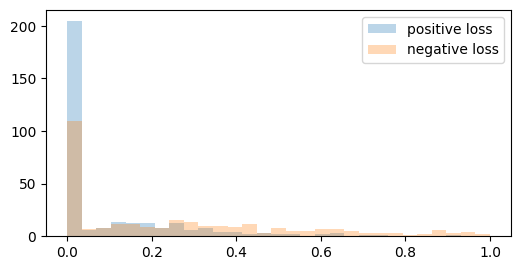

In [53]:
print_hist(pos_loss,neg_loss)

In [ ]:
max_pos = max(pos_loss)
min_neg = min(neg_loss)
print("maximum loss for positive pairs: ", max_pos)
print("minimum loss for negative pairs: ", min_neg)

In [ ]:
THRESHOLD = (max_pos+min_neg)/2
print("Threshold: ", THRESHOLD)

In [ ]:
THRESHOLD = 0.3

In [ ]:
def sigmoid(x, c1, c2):
  
    z = np.exp(-c1*(x-c2))
    sig = 1 / (1 + z)

    return sig

In [ ]:
xx = np.arange(-10,10,0.05)
plt.plot(xx,sigmoid(xx,1.,0.))
plt.show()

In [ ]:
fig,ax1 = plt.subplots(1,1,figsize=(6,3),dpi=100,num=1)
ax1.hist(pos_loss,bins=20,label='positive loss')
ax1.hist(neg_loss,bins=20,label='negative loss')
ax1.axvline(x=THRESHOLD, color="red", linestyle="--", lw=4)
ax2 = ax1.twinx()
xx = np.arange(0,0.6,0.01)
ax2.plot(xx, sigmoid(xx, 50., THRESHOLD),color='navy',lw=3)
plt.legend()
plt.show()

In [ ]:
def authentification_id(df, id_img1, id_img2, neg_imgs_idx, threshold):

    id_img3 = neg_imgs_idx[random.randint(0,len(neg_imgs_idx)-1)]

    img1 = df.Img.iloc[id_img1]
    img2 = df.Img.iloc[id_img2]
    img3 = df.Img.iloc[id_img3]

    anchor_img = torch.reshape(img1.to(device).float(), (1,3,60,60))
    positive_img = torch.reshape(img2.to(device).float(), (1,3,60,60))
    negative_img = torch.reshape(img3.to(device).float(), (1,3,60,60))

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    loss = criterion(anchor_out, positive_out, negative_out)
    print("Loss: ", loss.cpu().detach().numpy())

    if loss < threshold :
        return 1
    
    return 0

In [ ]:
Xa_neg

In [ ]:
### ARE SUPPOSED TO BE ALWAYS DIFFERENT

print("ARE SUPPOSED TO BE ALWAYS DIFFERENT")

rdm = random.randint(0,len(Xa_neg))

bin = authentification_id(df, Xa_neg[rdm], Xp_neg[rdm], all_img_neg_idx, THRESHOLD)

print_pairs(df, Xa_neg, Xp_neg, rdm)

if bin==1 :
    print("Same person")
else :
    print("Different people")

In [ ]:
### ARE SUPPOSED TO BE ALWAYS THE SAME

print("ARE SUPPOSED TO BE ALWAYS THE SAME")

rdm = random.randint(0,len(Xa_pos))

bin = authentification_id(df, Xa_pos[rdm], Xa_pos[rdm], all_img_neg_idx, THRESHOLD)

print_pairs(df, Xa_pos, Xp_pos, rdm)

if bin==1 :
    print("Same person")
else :
    print("Different people")

In [ ]:
def authentification_img(df, img1, img2, neg_imgs_idx, threshold, proba=False):

    id_img3 = neg_imgs_idx[random.randint(0,len(neg_imgs_idx)-1)]
    img3 = df.Img.iloc[id_img3]

    img1 = img1.to(device).float()
    img2 = img2.to(device).float()
    
    img3 = img3.to(device).float()

    anchor_img = torch.reshape(img1, (1,3,60,60))
    positive_img = torch.reshape(img2, (1,3,60,60))
    negative_img = torch.reshape(img3, (1,3,60,60))

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    loss = criterion(anchor_out, positive_out, negative_out)
    loss = loss.cpu().detach().numpy()
    # print("Loss: ", loss)

    if proba == True :
        return 1-sigmoid(loss, 50., threshold)
    else :
        if loss < threshold :
            return 1
        
        return 0

In [ ]:
def predict(df, loader, neg_imgs_idx, threshold, proba=False):
    bins=[]
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(loader, desc="Processing", leave=False)):
        for img in range(len(anchor_img)):
            bins.append(authentification_img(df, anchor_img[img], positive_img[img], neg_imgs_idx, threshold, proba))
    return bins

In [ ]:
y_pred_pos = predict(df, pos_loader, all_img_neg_idx, THRESHOLD)
y_pred_neg = predict(df, neg_loader, all_img_neg_idx, THRESHOLD)

In [ ]:
y_proba_pos = predict(df, pos_loader, all_img_neg_idx, THRESHOLD, proba=True)
y_proba_neg = predict(df, neg_loader, all_img_neg_idx, THRESHOLD, proba=True)

In [ ]:
y_pos = [1 for _ in range(len(y_pred_pos))]
y_neg = [0 for _ in range(len(y_pred_neg))]

In [ ]:
y_pred = y_pred_pos + y_pred_neg
y_proba = y_proba_pos + y_proba_neg
y = y_pos + y_neg

Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score

In [ ]:
print("Confusion Matrix Total")
confusion_matrix(y, y_pred)

In [ ]:
# help(confusion_matrix)

In [ ]:
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr,tpr)

In [ ]:
plt.figure()
lw=2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1], color="navy",lw=lw, linestyle="--")
plt.xlim([0.,1.])
plt.ylim([0.,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, y_proba)

In [ ]:
f1_s, auc_s = f1_score(y, y_pred), auc(recall, precision)
print('Logistic: f1=%.3f auc=%.3f' % (f1_s, auc_s))

plt.figure()
lw=2
plt.plot(recall, precision, color="darkorange", lw=lw, label="Precision-Recall curve")
plt.axhline(y=0.5, xmin=0.05, xmax=0.95, color="navy", linestyle="--", lw=lw)
plt.ylim([0.45,1.05])
plt.xlim([-0.05,1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

### Missclassified examples

In [ ]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

In [ ]:
mean = np.array([131.60774134, 105.40847531,  88.49154859])

In [ ]:
### MISCLASSIFIED EXAMPLES

misclass_idx = np.where(np.array(y_pred) != np.array(y))[0]

print("FALSE NEGATIVES")

for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(pos_loader, desc="Processing", leave=False)):
    for img in range(len(anchor_img)) :
        if img+BATCH_TEST_SIZE*step in misclass_idx :
            print(img+BATCH_TEST_SIZE*step)
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow((resize100(anchor_img[img].numpy().transpose((1, 2, 0)))+mean)/255)
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow((resize100(positive_img[img].numpy().transpose((1, 2, 0)))+mean)/255)
            plt.axis('off')
            plt.show()

### Testing on my imgs

In [ ]:
from skimage.io import imread
from skimage.transform import resize

In [ ]:
def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

In [ ]:
def print_my_img(path):
    plt.imshow(resize100(imread('./my_imgs/'+path))/255)
    plt.show()

In [ ]:
MY_IMGS_PATH = './my_imgs/'

In [ ]:
print_my_img('profil_rugby.jpg')

In [ ]:
print_my_img('profil_prepa.jpg')

In [ ]:
print_my_img('img_enfant.jpg')

In [ ]:
dirs = sorted(os.listdir(MY_IMGS_PATH))
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

my_img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(MY_IMGS_PATH+directory))] 
                for directory,c in name_to_classid.items()}

# retrieve all images
all_my_images_path = []
for img_list in my_img_paths.values():
    all_my_images_path += img_list

In [ ]:
all_my_images_path

In [ ]:
my_img_paths

In [ ]:
all_my_imgs = []
for path in all_my_images_path:
    all_my_imgs += [np.expand_dims(resize100(imread(MY_IMGS_PATH+path)),0)]
return np.vstack(all_imgs)

In [ ]:
def authentification(df, id_img1, id_img2, neg_imgs_idx, threshold):

    id_img3 = neg_imgs_idx[random.randint(0,len(neg_imgs_idx))]

    img1 = df.Img.iloc[id_img1]
    img2 = df.Img.iloc[id_img2]
    img3 = df.Img.iloc[id_img3]

    image_transforms = transforms.Compose(
              [
                  transforms.ToTensor(),
              ]
          )

    anchor_img = torch.reshape(image_transforms(img1).to(device).float(), (1,3,60,60))
    positive_img = torch.reshape(image_transforms(img2).to(device).float(), (1,3,60,60))
    negative_img = torch.reshape(image_transforms(img3).to(device).float(), (1,3,60,60))

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    loss = criterion(anchor_out, positive_out, negative_out)
    print("Loss: ", loss.cpu().detach().numpy())

    if loss < threshold :
        return 1
    
    return 0